In [ ]:
# REQUIRES INSTALLATION OF https://github.com/johli/genesis

In [ ]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, GlobalMaxPooling1D, concatenate
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

from keras.utils import plot_model

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

# from genesis_generator_protein import *
# from genesis_predictor_protein import *
from genesis_visualization import *
from genesis_generator import *
from genesis_predictor import *
from genesis_optimizer import *

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

In [2]:
#GENESIS Generator Model definitions

def make_deconv_resblock(n_channels=64, window_size=3, stride=1, dilation=1, group_ix=0, layer_ix=0) :

    #Initialize res block layers
    batch_norm_0 = BatchNormalization(name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x))
    
    deconv_0 = Conv2DTranspose(n_channels, (1, window_size), strides=(1, stride), padding='same', activation='linear', kernel_initializer='glorot_uniform', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_deconv_0')

    batch_norm_1 = BatchNormalization(name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x))

    conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=(1, dilation), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_uniform', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_deconv_0 = Conv2DTranspose(n_channels, (1, 1), strides=(1, stride), padding='same', activation='linear', kernel_initializer='glorot_uniform', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_deconv_0')
    
    skip_1 = Lambda(lambda x: x[0] + x[1], name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    #Execute res block
    def _resblock_func(input_tensor) :
        
        batch_norm_0_out = batch_norm_0(input_tensor, training=True)
        relu_0_out = relu_0(batch_norm_0_out)
        deconv_0_out = deconv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(deconv_0_out, training=True)
        relu_1_out = relu_1(batch_norm_1_out)
        conv_1_out = conv_1(relu_1_out)
        
        skip_deconv_0_out = skip_deconv_0(input_tensor)

        skip_1_out = skip_1([conv_1_out, skip_deconv_0_out])
        
        return skip_1_out

    return _resblock_func

def make_conv_resblock(n_channels=64, window_size=8, dilation=1, group_ix=0, layer_ix=0) :

    #Initialize res block layers
    batch_norm_0 = BatchNormalization(name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_0 = Conv2D(n_channels, (1, window_size), dilation_rate=(1, dilation), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    batch_norm_1 = BatchNormalization(name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=(1, dilation), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_1 = Lambda(lambda x: x[0] + x[1], name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    #Execute res block
    def _resblock_func(input_tensor) :
        batch_norm_0_out = batch_norm_0(input_tensor, training=True)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out, training=True)
        relu_1_out = relu_1(batch_norm_1_out)
        conv_1_out = conv_1(relu_1_out)

        skip_1_out = skip_1([conv_1_out, input_tensor])
        
        return skip_1_out

    return _resblock_func

def get_load_generator_network() :

    def _load_generator_network(batch_size, sequence_class, n_classes=1, n_out_channels=4, seq_length=145,supply_inputs=False) :

        #Generator network parameters
        latent_size = 100
        sequence_class_onehots = np.eye(n_classes)

        #Generator inputs
        latent_input_1 = Input(tensor=K.ones((batch_size, latent_size)), name='noise_input_1') #Input(batch_shape=(batch_size, latent_size))#
        latent_input_2 = Input(tensor=K.ones((batch_size, latent_size)), name='noise_input_2') #Input(batch_shape=(batch_size, latent_size))#
        latent_input_1_out = Lambda(lambda inp: inp * K.random_uniform((batch_size, latent_size), minval=-1.0, maxval=1.0), name='lambda_rand_input_1')(latent_input_1)
        latent_input_2_out = Lambda(lambda inp: inp * K.random_uniform((batch_size, latent_size), minval=-1.0, maxval=1.0), name='lambda_rand_input_2')(latent_input_2)
        
        class_embedding = Lambda(lambda x: K.gather(K.constant(sequence_class_onehots), K.cast(x[:, 0], dtype='int32')))(sequence_class)

        seed_input_1 = Concatenate(axis=-1)([latent_input_1_out, class_embedding])
        seed_input_2 = Concatenate(axis=-1)([latent_input_2_out, class_embedding])

#         seed_input_1 = latent_input_1_out
#         seed_input_2 = latent_input_2_out
        
        
        #Generator network parameters
        window_size = 3
        
        n_groups = 5
        n_resblocks_per_group = 2

        strides = [2, 2, 2, 2, 2]
        use_deconvs = [True, True, True, True, True]
        dilations = [1, 1, 1, 1, 1]
        channels = [384, 256, 128, 64, 32]
        initial_length = 5

        #Policy network definition
        policy_dense_0 = Dense(initial_length * channels[0], activation='linear', kernel_initializer='glorot_uniform', name='policy_generator_dense_0')
        policy_dense_0_reshape = Reshape((1, initial_length, channels[0]))

        resblock_deconvs = []
        skip_convs = []
        skip_adds = []
        resblock_groups = []
        for group_ix in range(n_groups) :
            
            if use_deconvs[group_ix] :
                resblock_deconvs.append(make_deconv_resblock(n_channels=channels[group_ix], window_size=window_size, stride=strides[group_ix], dilation=1, group_ix=group_ix, layer_ix=0))
            else :
                resblock_deconvs.append(None)
            
            if n_resblocks_per_group > 0 :
                skip_convs.append(Conv2D(channels[group_ix], (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_skip_conv_' + str(group_ix)))

                resblocks = []
                for layer_ix in range(n_resblocks_per_group) :
                    resblocks.append(make_conv_resblock(n_channels=channels[group_ix], window_size=window_size, dilation=dilations[group_ix], group_ix=group_ix, layer_ix=layer_ix+1))

                resblock_groups.append(resblocks)

                skip_adds.append(Lambda(lambda x: x[0] + x[1], name='skip_add_group_' + str(group_ix)))
        
        final_conv = Conv2D(n_out_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_uniform', name='policy_generator_final_conv')

        policy_permute = Lambda(lambda x: K.permute_dimensions(x, (0, 2, 3, 1))[:, :seq_length, ...])
        
        def _generator_func(seed_input) :
        
            policy_dense_0_out = policy_dense_0_reshape(policy_dense_0(seed_input))
#             print("policy_dense_0_out " + str(policy_dense_0_out.shape))

            #Connect group of res blocks
            output_tensor = policy_dense_0_out
            
            #Res block group execution
            for group_ix in range(n_groups) :
#                 print()
#                 print("-- Group " + str(group_ix) + " --")
                
                if use_deconvs[group_ix] :
                    output_tensor = resblock_deconvs[group_ix](output_tensor)
#                     print("resblock_deconvs_" + str(group_ix)+ " " + str(output_tensor.shape))
                
                if n_resblocks_per_group > 0 :
                    skip_conv_out = skip_convs[group_ix](output_tensor)
#                     print("skip_conv_out" + str(group_ix) + "     " + str(skip_conv_out.shape))

                    for layer_ix in range(n_resblocks_per_group) :
                        output_tensor = resblock_groups[group_ix][layer_ix](output_tensor)

                    output_tensor = skip_adds[group_ix]([output_tensor, skip_conv_out])
#                     print("output_tensor_" + str(group_ix) + "    " + str(output_tensor.shape))

            #Final conv out
            final_conv_out = final_conv(output_tensor)
#             print("final conv out " + str(final_conv_out.shape))

            return policy_permute(final_conv_out)

        policy_out_1 = _generator_func(seed_input_1)
        policy_out_2 = _generator_func(seed_input_2)

        return [latent_input_1, latent_input_2], [policy_out_1, policy_out_2], []
    
    return _load_generator_network


In [3]:
def get_pat_model(n_filters,filt_sizes,n_dense,dropout_rate):
    sequence_input = Input(shape=(145, 4),name="pat_input")
    convs = [None]*len(filt_sizes)
    
    for i in range(len(filt_sizes)):
        conv1           = Conv1D(n_filters, filt_sizes[i], padding='same', activation='linear', name = "pat_conv_" + str(i))(sequence_input)
        batchnorm1      = BatchNormalization(axis=-1,name = "pat_batchnorm_" + str(i))(conv1)
        relu1           = Activation('relu',name = "pat_relu_" + str(i))(batchnorm1)
        convs[i]        = Dropout(dropout_rate,name = "pat_dropout_" + str(i))(GlobalMaxPooling1D(name = "pat_pool_" + str(i))(relu1))
    
    concat1           = concatenate(convs,name="pat_concat_layer")

    dense           = Dense(n_dense,activation='relu',name="pat_dense")(concat1)
    output          = Dense(2,activation='linear',name="pat_output")(dense)

    model = Model(inputs=sequence_input,outputs=output)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.9, beta_2=0.999), loss="mse")
    return model

In [4]:
def load_predictor_model(model_path) :
    
    n_filters = 600
    filt_sizes = [25,11,7]
    n_dense = 64
    dropout_rate = 0.1
    
    sequence_input = Input(shape=(145, 4),name="pat_input")  
    convs = [None]*len(filt_sizes)
    
    for i in range(len(filt_sizes)):
        conv1           = Conv1D(n_filters, filt_sizes[i], padding='same', activation='linear', name = "pat_conv_" + str(i) + "_copy", trainable=False)(sequence_input)
        batchnorm1      = BatchNormalization(axis=-1,name = "pat_batchnorm_" + str(i) + "_copy", trainable=False)(conv1)
        relu1           = Activation('relu',name = "pat_relu_" + str(i) + "_copy")(batchnorm1)
        convs[i]        = Dropout(dropout_rate,name = "pat_dropout_" + str(i) + "_copy")(GlobalMaxPooling1D(name = "pat_pool_" + str(i) + "_copy")(relu1))
    
    concat1           = concatenate(convs,name="pat_concat_layer_copy")

    dense           = Dense(n_dense,activation='relu',name="pat_dense_copy", trainable=False)(concat1)
    output          = Dense(2,activation='linear',name="pat_output_copy", trainable=False)(dense)

    saved_model = Model(inputs=sequence_input,outputs=output)
    saved_model.compile(optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.9, beta_2=0.999), loss="mse")
    

    saved_model.load_weights(model_path)
    return saved_model

In [5]:
def load_saved_predictor(library_context=None) :
    
    # model_path = "mpra_predictor.h5"
    # model_path = "boot_0.h5"
    
    n_filters = 600
    filt_sizes = [25,11,7]
    n_dense = 64
    dropout_rate = 0.1
    
    sequence_input = Input(shape=(145, 4),name="pat_input")  
    convs = [None]*len(filt_sizes)
    
    for i in range(len(filt_sizes)):
        conv1           = Conv1D(n_filters, filt_sizes[i], padding='same', activation='linear', name = "pat_conv_" + str(i) + "_copy", trainable=False)(sequence_input)
        batchnorm1      = BatchNormalization(axis=-1,name = "pat_batchnorm_" + str(i) + "_copy", trainable=False)(conv1)
        relu1           = Activation('relu',name = "pat_relu_" + str(i) + "_copy")(batchnorm1)
        convs[i]        = Dropout(dropout_rate,name = "pat_dropout_" + str(i) + "_copy")(GlobalMaxPooling1D(name = "pat_pool_" + str(i) + "_copy")(relu1))
    
    concat1           = concatenate(convs,name="pat_concat_layer_copy")

    dense           = Dense(n_dense,activation='relu',name="pat_dense_copy", trainable=False)(concat1)
    output          = Dense(2,activation='linear',name="pat_output_copy", trainable=False)(dense)

    saved_model = Model(inputs=sequence_input,outputs=output)
    saved_model.compile(optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.9, beta_2=0.999), loss="mse")
    

    saved_model.load_weights(model_path)

    def _initialize_predictor_weights(predictor_model, saved_model=saved_model) :
        
        #Load pre-trained model
        predictor_layers = ["pat_conv_0", "pat_conv_1", "pat_conv_2", "pat_batchnorm_0", 
                       "pat_batchnorm_1", "pat_batchnorm_2", "pat_dense", "pat_output"]
            
        for layer in predictor_layers:
            predictor_model.get_layer(layer).set_weights(saved_model.get_layer(layer + "_copy").get_weights())
            # predictor_model.get_layer(layer + "_adv").set_weights(saved_model.get_layer(layer + "_copy").get_weights())
            
    def _dummy(predictor_model):
        print("dummy")


    def predictor_func(sequence_input,class_input, predictor_inputs, shared_inputs) :
        #DragoNN parameters
        seq_length = 145
        n_filters = 600
        filt_sizes = [25,11,7]
        n_dense = 64
        dropout_rate = 0.1
        
        seq_input_shape = (seq_length, 4, 1)
        n_tasks = 1

        #Define model layers
        permute_input = Lambda(lambda x: x[..., -1])
        
        permuted_input = permute_input(sequence_input)
        for i in range(len(filt_sizes)):
            conv1           = Conv1D(n_filters, filt_sizes[i], padding='same', activation='linear',
                                     name = "pat_conv_" + str(i), trainable=False)(permuted_input)
            batchnorm1      = BatchNormalization(axis=-1,name = "pat_batchnorm_" + str(i), trainable=False)(conv1)
            relu1           = Activation('relu',name = "pat_relu_" + str(i))(batchnorm1)
            convs[i]        = Dropout(dropout_rate,name = "pat_dropout_" + str(i))(GlobalMaxPooling1D(name = "pat_pool_" + str(i))(relu1))
        
        concat1           = concatenate(convs,name="pat_concat_layer")
    
        dense           = Dense(n_dense,activation='relu',name="pat_dense", trainable=False)(concat1)
        output          = Dense(2,activation='linear',name="pat_output", trainable=False)(dense)

        #Execute functional model definition
        predictor_outputs = [output]

        return predictor_outputs

    def predictor_func_adv(sequence_input,class_input, predictor_inputs, shared_inputs) :
        #DragoNN parameters
        seq_length = 145
        n_filters = 600
        filt_sizes = [25,11,7]
        n_dense = 64
        dropout_rate = 0.1
        
        seq_input_shape = (seq_length, 4, 1)
        n_tasks = 1

        #Define model layers
        permute_input = Lambda(lambda x: x[..., -1])
        
        permuted_input = permute_input(sequence_input)
        for i in range(len(filt_sizes)):
            conv1           = Conv1D(n_filters, filt_sizes[i], padding='same', activation='linear',
                                     name = "pat_conv_" + str(i) + "_adv", trainable=False)(permuted_input)
            batchnorm1      = BatchNormalization(axis=-1,name = "pat_batchnorm_" + str(i) + "_adv", trainable=False)(conv1)
            relu1           = Activation('relu',name = "pat_relu_" + str(i) + "_adv")(batchnorm1)
            convs[i]        = Dropout(dropout_rate,name = "pat_dropout_" + str(i) + "_adv")(GlobalMaxPooling1D(name = "pat_pool_" + str(i) + "_adv")(relu1))
        
        concat1           = concatenate(convs,name="pat_concat_layer_adv")
    
        dense           = Dense(n_dense,activation='relu',name="pat_dense_adv", trainable=False)(concat1)
        output          = Dense(2,activation='linear',name="pat_output_adv", trainable=False)(dense)

        #Execute functional model definition
        predictor_outputs = [output]

        return predictor_outputs
    
    predictor_inputs = []
    shared_callables = [] # might not work
    return predictor_inputs, shared_callables, predictor_func, predictor_func_adv, _initialize_predictor_weights

In [6]:
#Define target isoform loss function
def get_activity_loss(fitness_target, fitness_weight=1.0, seq_length=145, entropy_min_bits=1.0, entropy_weight=1.0, similarity_margin=0.5, similarity_weight=1.0) :

#     margin_entropy_ame = get_target_entropy_sme_masked(pwm_start=0, pwm_end=seq_length, target_bits=entropy_min_bits)
#     if entropy_loss_mode == 'margin' :
    margin_entropy_ame = get_margin_entropy_ame_masked(pwm_start=0, pwm_end=seq_length, min_bits=entropy_min_bits)
    
    sample_entropy_ame = get_pwm_margin_sample_entropy_masked(pwm_start=0, pwm_end=seq_length, margin=similarity_margin, shift_1_nt=True)

    
#     margin_entropy_ame = get_margin_entropy_ame(pwm_start=0, pwm_end=seq_length, min_bits=entropy_min_bits, n_channels=4)
#     sample_entropy_ame = get_pwm_margin_sample_entropy(pwm_start=0, pwm_end=seq_length, margin=similarity_margin)
    
    def _loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, score_pred = loss_tensors
        # _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, score_pred, _ = loss_tensors

        #Specify costs
        fitness_loss = fitness_weight * K.mean(K.maximum(-score_pred[..., 0] + score_pred[..., 1]+fitness_target, K.zeros_like(score_pred[..., 0])), axis=1)

        similarity_loss = similarity_weight * K.mean(sample_entropy_ame(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1)
        
        entropy_loss = entropy_weight * margin_entropy_ame(pwm_1, mask)
        
        #Compute total loss
        total_loss = fitness_loss + similarity_loss + entropy_loss

        return total_loss
    
    return _loss_func

def build_loss_model(predictor_model, loss_func, extra_loss_tensors=[]) :
#     print("Predictor Model Inputs Cnt: " + str(len(predictor_model.inputs)))
#     print("Predictor Model Outputs Cnt: " + str(len(predictor_model.outputs)))

    loss_out = Lambda(lambda out: loss_func(out), output_shape = (1,),name="loss_out")(predictor_model.inputs + predictor_model.outputs + extra_loss_tensors)
    print("loss out shape: " + str(loss_out.shape))
    loss_model = Model(predictor_model.inputs, loss_out)

    return 'loss_model', loss_model

#Function for running GENESIS
def run_genesis(loss_func, load_predictor_func, accum_iters=1, seq_len=100, batch_size=32, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    #Build Generator Network
    _, generator = build_generator(batch_size, seq_len, get_load_generator_network(), n_classes=1, n_samples=n_samples, sequence_templates=None, batch_normalize_pwm=False)
#     _, generator = build_generator(batch_size, seq_len, get_load_generator_network(), n_classes=1, n_samples=n_samples, sequence_templates=None, batch_normalize_pwm=False, supply_inputs=True)

    #Build Predictor Network and hook it on the generator PWM output tensor
    _, predictor = build_predictor_w_adversary(generator, load_predictor_func, batch_size, n_samples=n_samples, eval_mode='sample')

    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, loss_model = build_loss_model(predictor, loss_func)
    
    #Specify Optimizer to use
    #opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9, clipvalue=0.5)
#     opt = AdamAccumulate(lr=0.0001, beta_1=0.5, beta_2=0.9, accum_iters=accum_iters)
    
    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

    #Fit Loss Model
#     train_history = loss_model.fit(
#         [np.zeros((batch_size, 1)),np.ones((batch_size, 100)),np.ones((batch_size, 100))], np.ones((batch_size, 1)),
#         epochs=n_epochs,
#         steps_per_epoch=steps_per_epoch,
#         batch_size = batch_size
#     )
    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch
    )
    
    train_history = train_history.history

    return generator, predictor, train_history


In [7]:
seq_length = 145
#Number of PWMs to generate per epoch
batch_size = 64

#Number of samples
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 100
#Number of steps (grad updates) per epoch
steps_per_epoch = 100

loss_func = get_activity_loss(
    2.5,
    fitness_weight=0.1,
    seq_length=145,
    entropy_min_bits=1.8,
    entropy_weight=0.5,
    similarity_margin=0.5,
    similarity_weight=5.0
)

save_dir = 'saved_models'

In [11]:
import os
print(os.getcwd())
gen_dir = f"{os.getcwd()}\..\generator_models\single_DENS"
# gen_dir = "C:\\Users\\chhyi\\Desktop\\UW\\Seelig_Lab\\aws\\for_aws\\generator_models\\single_DENS".
pred_dir = f"{os.getcwd()}\..\predictor_models"

seq_file_prefix = "h2k_single_DEN"

C:\Users\chhyi\Desktop\UW\Seelig_Lab\aws\for_aws\generator_inference


In [8]:
import time

In [12]:
batch_size = 64
n = 1000
n_slack = 0.05 * n

n_ceil = int((n + n_slack) / batch_size) * batch_size + batch_size

sequence_class = np.array([0] * n_ceil).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #
acgt_encoder = IdentityEncoder(145, {'A':0, 'C':1, 'G':2, 'T':3})

with open(seq_file_prefix + "_sequences.csv", "wt") as f:


    for pred_type in ["boot"]:
        for gen_i in [5]:#range(10):
            t0 = time.time()
            K.clear_session()
            
            print(f"Loading {pred_type} model {gen_i}")
            # load generator and predictor
            gen_model_path = f"{gen_dir}\\{pred_type}_{gen_i}.h5_minp_hepg2-k562_fw01_ft2_5_generator.h5"
            generator = load_model(gen_model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax},compile=False)
            pred_model_path = f"{pred_dir}\\{pred_type}_predictors\\{pred_type}_{gen_i}.h5"
            saved_predictor =  load_predictor_model(pred_model_path)

            # generate 64 sequences
            noise_1 = np.random.uniform(-1, 1, (n_ceil, 100))
            noise_2 = np.random.uniform(-1, 1, (n_ceil, 100))

            pred_outputs = generator.predict([sequence_class, noise_1, noise_2], batch_size=batch_size)

            _, _, _, optimized_pwm, _, sampled_pwm, _, _, _ = pred_outputs


            onehots = sampled_pwm[:, 0, :, :, 0]

            #Make predictions, sort, and take top 10 seqs

            score_pred = saved_predictor.predict(x=[onehots], batch_size=batch_size)

#             score_pred = np.ravel(score_pred[:, 1] - score_pred[:, 0]) # K2H
            score_pred = np.ravel(score_pred[:, 0] - score_pred[:, 1]) # H2K

            sort_index = np.argsort(score_pred)[::-1]

            onehots = onehots[sort_index][:10]
            score_pred = score_pred[sort_index][:10]

            seqs = [
                acgt_encoder.decode(onehots[i, :, :]) for i in range(onehots.shape[0])
            ]
            
            # write all generated sequences to file
            for i in range(10) :
                seq = seqs[i]
                score = score_pred[i]
                f.write(f"{seq}, {score}, single_DENS_{pred_type}, {pred_type}_{gen_i}\n")
                
            t1 = time.time()
            del generator, saved_predictor
            print(f"Time: {t1-t0}")
        
        

Loading boot model 5
Time: 13.440828800201416


In [20]:
generator = load_model(f"{gen_dir}\\wide_4.h5_minp_k562-hepg2_fw01_ft2_5_generator.h5", custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax},compile=False)

In [21]:
saved_predictor = load_predictor_model(f"{pred_dir}/wide_predictors/wide_4.h5")

In [22]:
batch_size = 64
n = 1000
n_slack = 0.05 * n

n_ceil = int((n + n_slack) / batch_size) * batch_size + batch_size

sequence_class = np.array([0] * n_ceil).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #
acgt_encoder = IdentityEncoder(145, {'A':0, 'C':1, 'G':2, 'T':3})

noise_1 = np.random.uniform(-1, 1, (n_ceil, 100))
noise_2 = np.random.uniform(-1, 1, (n_ceil, 100))

pred_outputs = generator.predict([sequence_class, noise_1, noise_2], batch_size=batch_size)

_, _, _, optimized_pwm, _, sampled_pwm, _, _, _ = pred_outputs

pwms = optimized_pwm[:, :, :, 0]
onehots = sampled_pwm[:, 0, :, :, 0]

#Make predictions using black box model

score_pred = saved_predictor.predict(x=[onehots], batch_size=batch_size)

# score_pred = np.ravel(score_pred[:, 1] - score_pred[:, 0]) # K2H
score_pred = np.ravel(score_pred[:, 0] - score_pred[:, 1]) # H2K

sort_index = np.argsort(score_pred)[::-1]

pwms = pwms[sort_index][:n]
onehots = onehots[sort_index][:n]
score_pred = score_pred[sort_index][:n]


acgt_encoder = IdentityEncoder(145, {'A':0, 'C':1, 'G':2, 'T':3})


seqs = [
    acgt_encoder.decode(onehots[i, :, :]) for i in range(onehots.shape[0])
]

In [ ]:
# f"{seq}, {score}, {gen_model_type},{pred_models_used_for_gen}"

In [24]:
#Save sequences to file
with open(seq_file_prefix + "_sequences.csv", "wt") as f:
    for i in range(n) :
        seq = seqs[i]
#         score = score_pred[i]
        f.write(">seq" + str(i) + "\n" + seq + "\n")
#         f.write(f"{seq}, {score}, single_DENS_boot, boot_0\n")


    

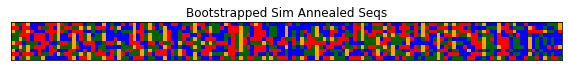

In [60]:
plot_n_seqs = 10
plot_start = 0
plot_end = 145

save_figs = False

flat_pwms = np.zeros((n, 145))
for i in range(n) :
    for j in range(145) :
        max_nt_ix = np.argmax(onehots[i, j, :])

        flat_pwms[i, j] = max_nt_ix + 1

flat_pwms = flat_pwms[:plot_n_seqs, plot_start:plot_end]

cmap = colors.ListedColormap(['red', 'blue', 'orange', 'darkgreen'])
bounds=[1, 2, 3, 4, 5]
norm = colors.BoundaryNorm(bounds, cmap.N)

f = plt.figure(figsize=(8, 24))

plt.imshow(flat_pwms, aspect='equal', interpolation='nearest', origin='lower', cmap=cmap, norm=norm)

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()

if save_figs :
    plt.savefig(model_prefix + "_diversity_seqs.png", transparent=True, dpi=150)
    plt.savefig(model_prefix + "_diversity_seqs.svg")
    plt.savefig(model_prefix + "_diversity_seqs.eps")

plt.title("Bootstrapped Sim Annealed Seqs")
plt.show()